In [16]:
# Docker for venvs
# pdb stuff

In [1]:
from __future__ import absolute_import, division, print_function

import base64
# import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# import PIL.Image
# import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

2022-01-20 11:58:09.244331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 11:58:09.244356: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
from numpy import int32, float32

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts


class PyEnvironment(object):

    def reset(self):
        """Return initial_time_step."""
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        """Apply action and return new time_step."""
        if self._current_time_step is None:
            return self.reset()
        self._current_time_step = self._step(action)
        return self._current_time_step

    def current_time_step(self):
        return self._current_time_step

    def time_step_spec(self):
        """Return time_step_spec."""

    @abc.abstractmethod
    def observation_spec(self):
        """Return observation_spec."""

    @abc.abstractmethod
    def action_spec(self):
        """Return action_spec."""

    @abc.abstractmethod
    def _reset(self):
        """Return initial_time_step."""

    @abc.abstractmethod
    def _step(self, action):
        """Apply action and return new time_step."""

        
class SatEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._num_look_spots = 50
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=self._num_look_spots, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False
    self._episode_duration = 0
    self._max_episode_length = 20

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    # self._state = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state], dtype=np.int32))

  def _step(self, action):

    reward = 0
    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    self._episode_duration += 1

    # Make sure episodes don't go on forever.
    if action == self._state:
        reward = 1

    self._state = (self._state + 1) % self._num_look_spots
    # print(self._state)
    # print("reward = ", reward)


    if self._episode_duration >= self._max_episode_length:
        self._episode_ended = True
        return ts.termination(np.array([self._state], dtype=np.int32), reward)
    else:
        return ts.transition(
            np.array([self._state], dtype=np.int32), reward=reward, discount=1.0)


env = SatEnv()
utils.validate_py_environment(env, episodes=10)

tf_env = tf_py_environment.TFPyEnvironment(env)
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)

env.reset()

num_episodes: 5 num_steps: 5
avg_length 1.0 avg_reward: 0.0


2022-01-20 11:58:18.081111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 11:58:18.081136: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 11:58:18.081152: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubu-bOdGfe8O): /proc/driver/nvidia/version does not exist
2022-01-20 11:58:18.081383: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([34], dtype=int32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [4]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [5]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [7]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [8]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

compute_avg_return(eval_env, random_policy, num_eval_episodes)

0.0

In [9]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmp6gncunto.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmp6gncunto
[reverb/cc/platform/default/server.cc:71] Started replay server on port 17080


In [10]:
agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [11]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0., dtype=float32),
  'observation': array([44], dtype=int32),
  'reward': array(0., dtype=float32),
  'step_type': array(2, dtype=int32)}),
 ())

In [12]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

iterator = iter(dataset)
print(iterator)

In [ ]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

#   if step % log_interval == 0:
#     print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:163] Sampler and server are owned by the same process (50176) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (50176) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (50176) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (50176) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (50176) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:163] Sampler and server are owned by the same process (50176) so Table uniform_table is accessed directly without gRPC.


step = 1000: Average Return = 0.0
step = 2000: Average Return = 0.0
step = 3000: Average Return = 0.10000000149011612
step = 4000: Average Return = 0.0
step = 5000: Average Return = 0.20000000298023224
step = 6000: Average Return = 0.10000000149011612
step = 7000: Average Return = 0.0
step = 8000: Average Return = 0.0
step = 9000: Average Return = 0.0
step = 10000: Average Return = 0.30000001192092896
step = 11000: Average Return = 0.10000000149011612
step = 12000: Average Return = 0.10000000149011612
step = 13000: Average Return = 0.0
step = 14000: Average Return = 0.0
step = 15000: Average Return = 0.4000000059604645
step = 16000: Average Return = 0.20000000298023224
step = 17000: Average Return = 0.0


Text(0.5, 0, 'Iterations')

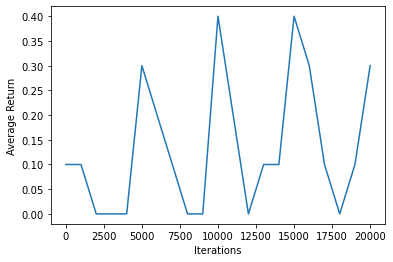

In [30]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
# plt.ylim(top=250)